In [1]:
import jax
import jax.numpy as np
import scipy
from jax import random, grad,value_and_grad, vmap, jit, hessian, lax
from jax.lax.linalg import qr
from jax.example_libraries import optimizers
from jax.nn import relu
#from jax.config import config
from jax.numpy import index_exp as index
from jax.flatten_util import ravel_pytree
from jax import flatten_util
import itertools
from functools import partial
from tqdm import trange, tqdm
import numpy as np0
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

import scipy.io as sio
import tqdm as tqdm
import sys
import os
from sklearn.model_selection import train_test_split


from scipy.interpolate import griddata
%matplotlib inline

file_path = os.getcwd()
project_root = os.path.dirname(os.path.dirname(file_path))
print(f"Project root: {project_root}")
if project_root not in sys.path:
    sys.path.append(project_root)

from flax import linen as nn
import jax.numpy as jnp
from typing import Sequence, Callable
from Crunch.Models.layers import  *
from Crunch.Models.polynomials import  *
from Crunch.Auxiliary.metrics import  *


Project root: /oscar/data/gk/jdtoscan/References/KKANs/Kurkova-Kolmogorov-Arnold-Newtorks-KKANs


In [2]:

cmap = 'RdBu'
num_colors=8
# Create a colormap
cmap = plt.get_cmap(cmap)
colors = [cmap(i) for i in np.linspace(0, 1, num_colors)]
colors=colors[:num_colors//4]+colors[3*num_colors//4:]
print(len(colors))
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 20

4


In [3]:
Save_name='QR-DeepOcKAN'

## Load Data


In [4]:
data=scipy.io.loadmat(project_root+'/Data/Burger_100pi_5000.mat')
print(data.keys())
s_all=data['output']
print(s_all.shape)
s_all = np.reshape(s_all, (s_all.shape[0], s_all.shape[1]*s_all.shape[2]))
print(s_all.shape)
f_all=data['input']
print(f_all.shape)
x_all=np.linspace(0, 1, f_all.shape[1])
t_all=np.linspace(0, 1, f_all.shape[1])
T, X = np.meshgrid(t_all, x_all)
y_all = np.hstack([T.flatten()[:,None], X.flatten()[:,None]])
print(y_all.shape)

dict_keys(['__header__', '__version__', '__globals__', 'gamma', 'input', 'output', 'sigma', 'tau', 'tspan'])
(5000, 101, 101)
(5000, 10201)
(5000, 101)
(10201, 2)


# Training-Testing Data

In [5]:
# Calculate the sizes for each split
train_size = 0.7

# First, split off the training data
s_train, s_test, f_train, f_test = train_test_split(s_all, f_all, train_size=train_size, random_state=42)

# Reshape the data 
s_train = np.float32(s_train)
y_train = np.float32(y_all)
f_train = np.float32(f_train)
# Reshape the data 
s_test = np.float32(s_test)
f_test = np.float32(f_test)
y_train = np.float32(y_train)

# Print shapes to verify
print("s_train shape:", s_train.shape)
print("f_train shape:", f_train.shape)
print("s_test shape:", s_test.shape)
print("f_test shape:", f_test.shape)

s_train shape: (3500, 10201)
f_train shape: (3500, 101)
s_test shape: (1500, 10201)
f_test shape: (1500, 101)


In [6]:
X_DN={'F':f_train,
      'y':y_train,
      'U':s_train,}
X_DN['F'].shape

X_Test={'F':f_test,
      'y':y_train,
      'U':s_test,}
X_DN['X_Test']=X_Test

# Architecture

In [7]:
class KART_Net(nn.Module):
    features: Sequence[int]
    degree: int=5
    degree_T: int=5
    M: int = 10
    output_dim: int =1
    activation: Callable = nn.tanh
    def setup(self):
        # Initialize the GetPhi submodule
        self.get_Psi = get_Psi(degree=self.degree_T, features=self.features, M=self.M)
    @nn.compact
    def __call__(self, X):
        # Process inputs through the GetPhi function
        inputs = [X[:,0:1],X[:,1:2]]
        sum_psi = self.get_Psi(inputs)
        # Final transformation through RBF_KAN_layer
        sum_Phi = RBF_KAN_layer(out_dim=self.output_dim, degree=self.degree)(sum_psi)
        return sum_Phi

# DeepONet

In [8]:
class KAN(nn.Module):
    layers: Sequence[int]
    degree: int =5
    @nn.compact
    def __call__(self, x):
        for feat in self.layers:
            x = Cheby_KAN_layer(out_dim=feat, degree=self.degree)(x)
        return x
def init_A(rng_key, N,K):
    k1, k2 = random.split(rng_key)
    glorot_stddev = 1. / np.sqrt((N + K) / 2.)
    A= glorot_stddev * random.normal(k1, (N, K))
    return A

In [9]:
# Define the model
class QR_DeepONet:
    def __init__(self, branch_layers, trunk_layers,X_data,N_fx,output_dim):    
        # Network initialization and evaluation functions
        self.branch_net = KAN(branch_layers)
        self.trunk_net = KAN(trunk_layers) 

        # Initialize parameters
        rng_branch = random.PRNGKey(1234)
        rng_trunk = random.PRNGKey(4321)
        
        # Sample inputs for initialization
        sample_F = X_data['F'][0:10]  # Adjust as needed
        sample_y = X_data['y'][0:10]  # Adjust as needed
        
        branch_params = self.branch_net.init(rng_branch, sample_F)
        trunk_params = self.trunk_net.init(rng_trunk, sample_y)
        A= init_A(rng_key=random.PRNGKey(4321),N=trunk_layers[-1],K=N_fx)
        params = (branch_params, trunk_params,A)
        # JIT-compile the apply functions
        self.branch_apply = jax.jit(self.branch_net.apply)
        self.trunk_apply  = jax.jit(self.trunk_net.apply)

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3/3, 
                                                                      decay_steps=2000, 
                                                                      decay_rate=0.99))
        self.opt_state = self.opt_init(params)

        # Used to restore the trained model parameters
        _, self.unravel_params = ravel_pytree(params)

        self.itercount = itertools.count()

        # Loggers
        self.loss_log_T = []
        self.it_log_T = []
        self.loss_log_B = []
        self.it_log_B = []
        self.train_L2 = []
        self.test_L2 = []

    # Define boundary loss
    def loss_trunk(self, params, y,U):
        _, trunk_params,A = params
        Phi = self.trunk_apply(trunk_params, y)
        loss=np.sum((np.matmul(Phi,A)-U)**2)
        return  loss
    # Define boundary loss
    def loss_branch(self, params,RA,F):
        branch_params, trunk_params,A  = params
        C = self.branch_apply(branch_params, F)
        loss=np.sum((C-RA)**2)
        return  loss
    # Define DeepONet architecture
    def operator_net(self, params, u, x, t):
        branch_params, trunk_params, A = params
        y = np.stack([x, t])
        B = self.branch_apply(branch_params, u)
        T = self.trunk_apply(trunk_params, y)
        
        outputs = np.sum(B * T)
        return  outputs

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step_trunk(self, i, opt_state, y,U):
        params = self.get_params(opt_state)
        g = grad(self.loss_trunk)(params,  y,U)
        return self.opt_update(i, g, opt_state)
    @partial(jit, static_argnums=(0,))
    def step_branch(self, i, opt_state,RA,F):
        params = self.get_params(opt_state)
        g = grad(self.loss_branch)(params, RA,F)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train_trunk(self, X_data, nIter = 10000):
        y=X_data['y']
        U=X_data['U'].T
        pbar = trange(nIter+1)
        for it in  pbar:
            self.opt_state = self.step_trunk(next(self.itercount), self.opt_state, y,U)           
            if it<=100 or it % 100 == 0:
                params = self.get_params(self.opt_state)            
                loss_value = self.loss_trunk(params, y,U)
                # Store losses
                self.loss_log_T.append(loss_value)
                self.it_log_T.append(it)
                # Print losses
                pbar.set_postfix({'Loss': loss_value})
        # Optimize parameters in a loop
    def train_branch(self, X_data, nIter = 10000):
        # Perform QR decomposition
        # Define a new optimizer with the updated learning rate and decay
        new_opt_init, new_opt_update, _ = optimizers.adam(optimizers.exponential_decay(
                                                            2e-3/3,
                                                            decay_steps=5000,
                                                            decay_rate=0.99))

        # Reinitialize the optimizer state with the current parameters
        params = self.get_params(self.opt_state)
        self.opt_state = new_opt_init(params)

        # Update the opt_update method
        self.opt_update = new_opt_update
        branch_params, trunk_params,A = params
        y=X_data['y']
        U=X_data['U'].T
        F=X_data['F']
        Phi = self.trunk_apply(trunk_params, y)
        print(f'Shapes: Phi{Phi.shape}, U:{U.shape}')
        A_s=scipy.linalg.lstsq(Phi,U)[0]
        C = self.branch_apply(branch_params, F)
        Q_s,R_s=np.linalg.qr(Phi)
        print(f'Shapes: A{A_s.shape}, R_s:{R_s.shape}')
        RA=np.matmul(R_s,A_s).T
        print(f'Shapes: RA{RA.shape}, C:{C.shape}')
        # Main training loop
        pbar = trange(nIter+1)
        base=10
        for it in  pbar:
            self.opt_state = self.step_branch(next(self.itercount), self.opt_state, RA,F)
            computed=0
            log_frequency = 1 if it < 200 else 100 if it <= 5000 else 500
            if it % log_frequency == 0:
                params = self.get_params(self.opt_state) 
                loss_value = self.loss_branch(params, RA,F)
                error_test, error_train  =self.test_error(params, X_data)
                # Store losses
                self.loss_log_B.append(loss_value)
                self.it_log_B.append(it)
                self.train_L2.append(error_train)
                self.test_L2.append(error_test)
                # Print losses
                pbar.set_postfix({'it':it,
                                  'Loss': loss_value,
                                  'Train RL2':error_train,
                                  'Test RL2':error_test})

    def predict(self, params, X_data):
        # Perform QR decomposition
        branch_params, trunk_params,A = params
        y=X_data['y']
        U=X_data['U'].T
        F=X_data['F']
        Phi = self.trunk_apply(trunk_params, y)
        A_s=scipy.linalg.lstsq(Phi,U)[0]
        C = self.branch_apply(branch_params, F)
        Q,R=scipy.linalg.qr(Phi,mode='economic')
        T=np.linalg.inv(R)
        PhiT=np.matmul(Phi,T).T
        U_pred=np.einsum('ij,jk->ik',C,PhiT)
        return U_pred
    def test_error(self, params, X_data):
        u_pred = self.predict(params, X_data)
        error_train = np.linalg.norm(X_data['U'] - u_pred) / np.linalg.norm(X_data['U'])
        X_Test=X_data['X_Test']
        u_pred = model.predict(params, X_Test)
        error_test = np.linalg.norm(X_Test['U'] - u_pred) / np.linalg.norm(X_Test['U']) 
        return error_test, error_train  
        

In [10]:
print(X_DN['y'].shape)
print(X_DN['U'].shape)
print(X_DN['F'].shape)

(10201, 2)
(3500, 10201)
(3500, 101)


## Initialize DeepONet

In [11]:
N=3500
batch_size=500
num_layer=5
width_layer=32
embed_dim=101
# Initialize model
branch_layers = num_layer*[width_layer] +[embed_dim]
trunk_layers =  num_layer*[width_layer] +[embed_dim]
print(branch_layers)
print(trunk_layers)
model = QR_DeepONet(branch_layers, trunk_layers,X_DN,N_fx=N,output_dim=embed_dim)
params_save=model.get_params(model.opt_state)
total_params = sum(x.size for x in jax.tree_util.tree_leaves(params_save) if hasattr(x, 'size'))
print(total_params)

[32, 32, 32, 32, 32, 101]
[32, 32, 32, 32, 32, 101]


2025-06-16 14:57:30.812064: W external/xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1117] Compiling 34 configs for gemm_fusion_dot on a single thread.
2025-06-16 14:57:36.147263: W external/xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1117] Compiling 34 configs for gemm_fusion_dot on a single thread.
2025-06-16 14:57:38.947571: W external/xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1117] Compiling 33 configs for gemm_fusion_dot on a single thread.
2025-06-16 14:57:44.128394: W external/xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1117] Compiling 2 configs for gemm_fusion_dot on a single thread.


461212


# Train

In [12]:
# Train
model.train_trunk(X_DN, nIter=200000)

  0%|          | 0/200001 [00:00<?, ?it/s]

2025-06-16 14:57:46.221042: W external/xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1120] Compiling 363 configs for 11 fusions on a single thread.
100%|██████████| 200001/200001 [11:22<00:00, 293.09it/s, Loss=259.5814] 


In [13]:
model.train_branch(X_DN, nIter=400000)

Shapes: Phi(10201, 101), U:(10201, 3500)


2025-06-16 15:09:09.171514: W external/xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1120] Compiling 103 configs for 3 fusions on a single thread.


Shapes: A(101, 3500), R_s:(101, 101)


2025-06-16 15:09:32.382686: W external/xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1117] Compiling 35 configs for gemm_fusion_dot.3 on a single thread.


Shapes: RA(3500, 101), C:(3500, 101)


  0%|          | 0/400001 [00:00<?, ?it/s]2025-06-16 15:09:42.121981: W external/xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1120] Compiling 169 configs for 5 fusions on a single thread.
2025-06-16 15:10:34.652842: W external/xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1117] Compiling 34 configs for gemm_fusion_dot.3 on a single thread.
2025-06-16 15:10:49.027627: W external/xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1117] Compiling 34 configs for gemm_fusion_dot.3 on a single thread.
2025-06-16 15:11:03.379617: W external/xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1120] Compiling 104 configs for 3 fusions on a single thread.
2025-06-16 15:11:20.951758: W external/xla/xla/service/gpu/autotuning/gemm_fusion_autotuner.cc:1117] Compiling 34 configs for gemm_fusion_dot.3 on a single thread.
100%|██████████| 400001/400001 [24:48<00:00, 268.79it/s, it=4e+5, Loss=361.472, Train RL2=0.022090899, Test RL2=0.056726843]    


## Save Parameters

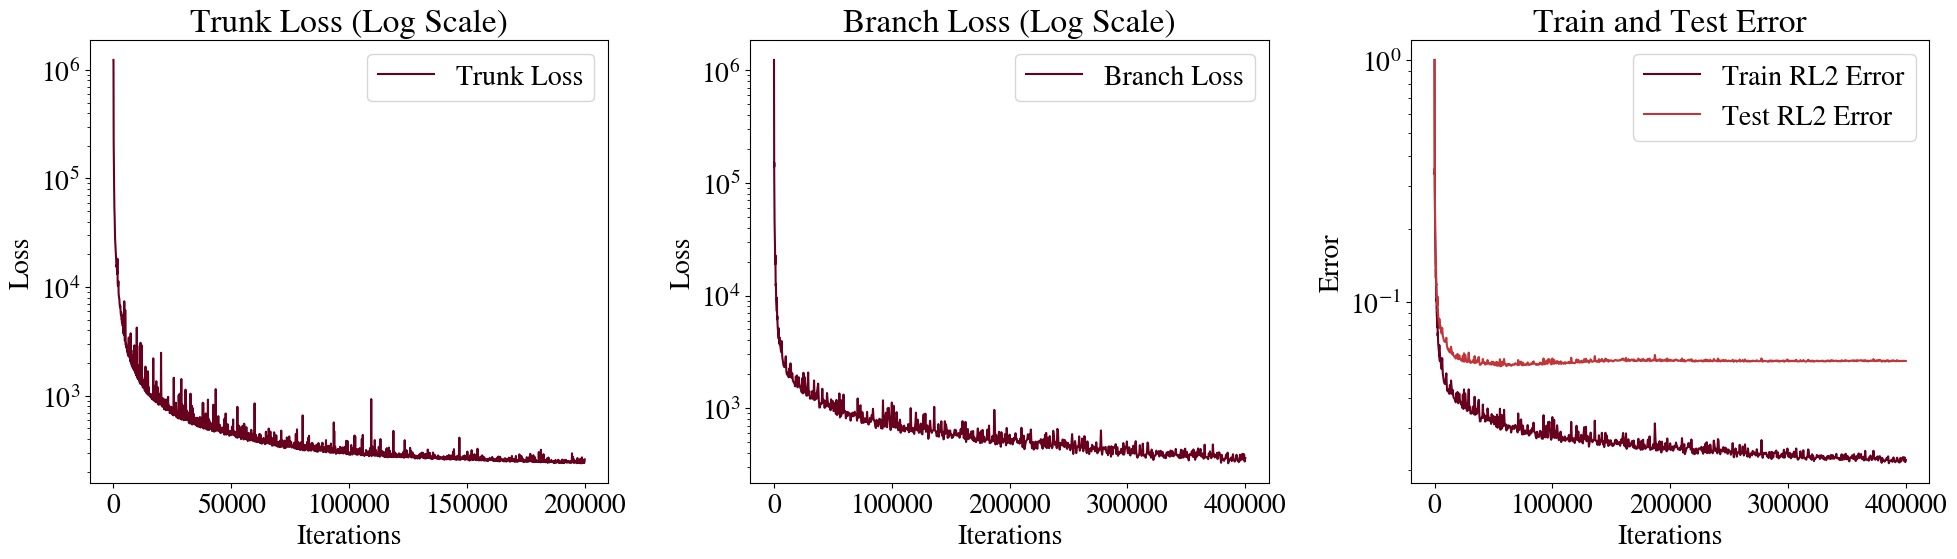

In [14]:
Loss_T=model.loss_log_T
it_T=model.it_log_T
Loss_B=model.loss_log_B
it_B=model.it_log_B
Train_error=model.train_L2
Test_error=model.test_L2

# Adding an additional subplot for Train and Test error

plt.figure(figsize=(20, 6))  # Adjusted figure size to accommodate three subplots

# Plot for Trunk loss with log scale
plt.subplot(1, 3, 1)
plt.plot(it_T, Loss_T, label='Trunk Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')  # Setting log scale for y-axis
plt.title('Trunk Loss (Log Scale)')
plt.legend()

# Plot for Branch loss with log scale
plt.subplot(1, 3, 2)
plt.plot(it_B, Loss_B, label='Branch Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')  # Setting log scale for y-axis
plt.title('Branch Loss (Log Scale)')
plt.legend()

# Plot for Train and Test error
plt.subplot(1, 3, 3)
plt.plot(it_B, Train_error, label='Train RL2 Error')
plt.plot(it_B, Test_error, label='Test RL2 Error')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.yscale('log')  # Setting log scale for y-axis
plt.title('Train and Test Error')
plt.legend()

# Displaying the plots
plt.tight_layout()
plt.show()


In [15]:
file_mat=Save_name+'_Errors.mat'

print(file_mat)
all_results={
    'Test':Test_error,
    'Train':Train_error,
    'it':it_B,
}
scipy.io.savemat(file_mat,all_results)

QR-DeepOcKAN_Errors.mat


In [16]:
params=jax.device_get(model.get_params(model.opt_state))
u_pred = model.predict(params, X_DN)
error_s = np.linalg.norm(X_DN['U'] - u_pred) / np.linalg.norm(X_DN['U'])

print(u_pred.shape)
print(error_s)

params=model.get_params(model.opt_state)
u_pred = model.predict(params, X_Test)
error_s = np.linalg.norm(X_Test['U'] - u_pred) / np.linalg.norm(X_Test['U'])

print(u_pred.shape)
print(error_s)

(3500, 10201)
0.022090899
(1500, 10201)
0.056726843


### Visualization

Sample 15 error_s: 3.356e-02
Sample 50 error_s: 2.418e-02
Sample 499 error_s: 2.574e-02


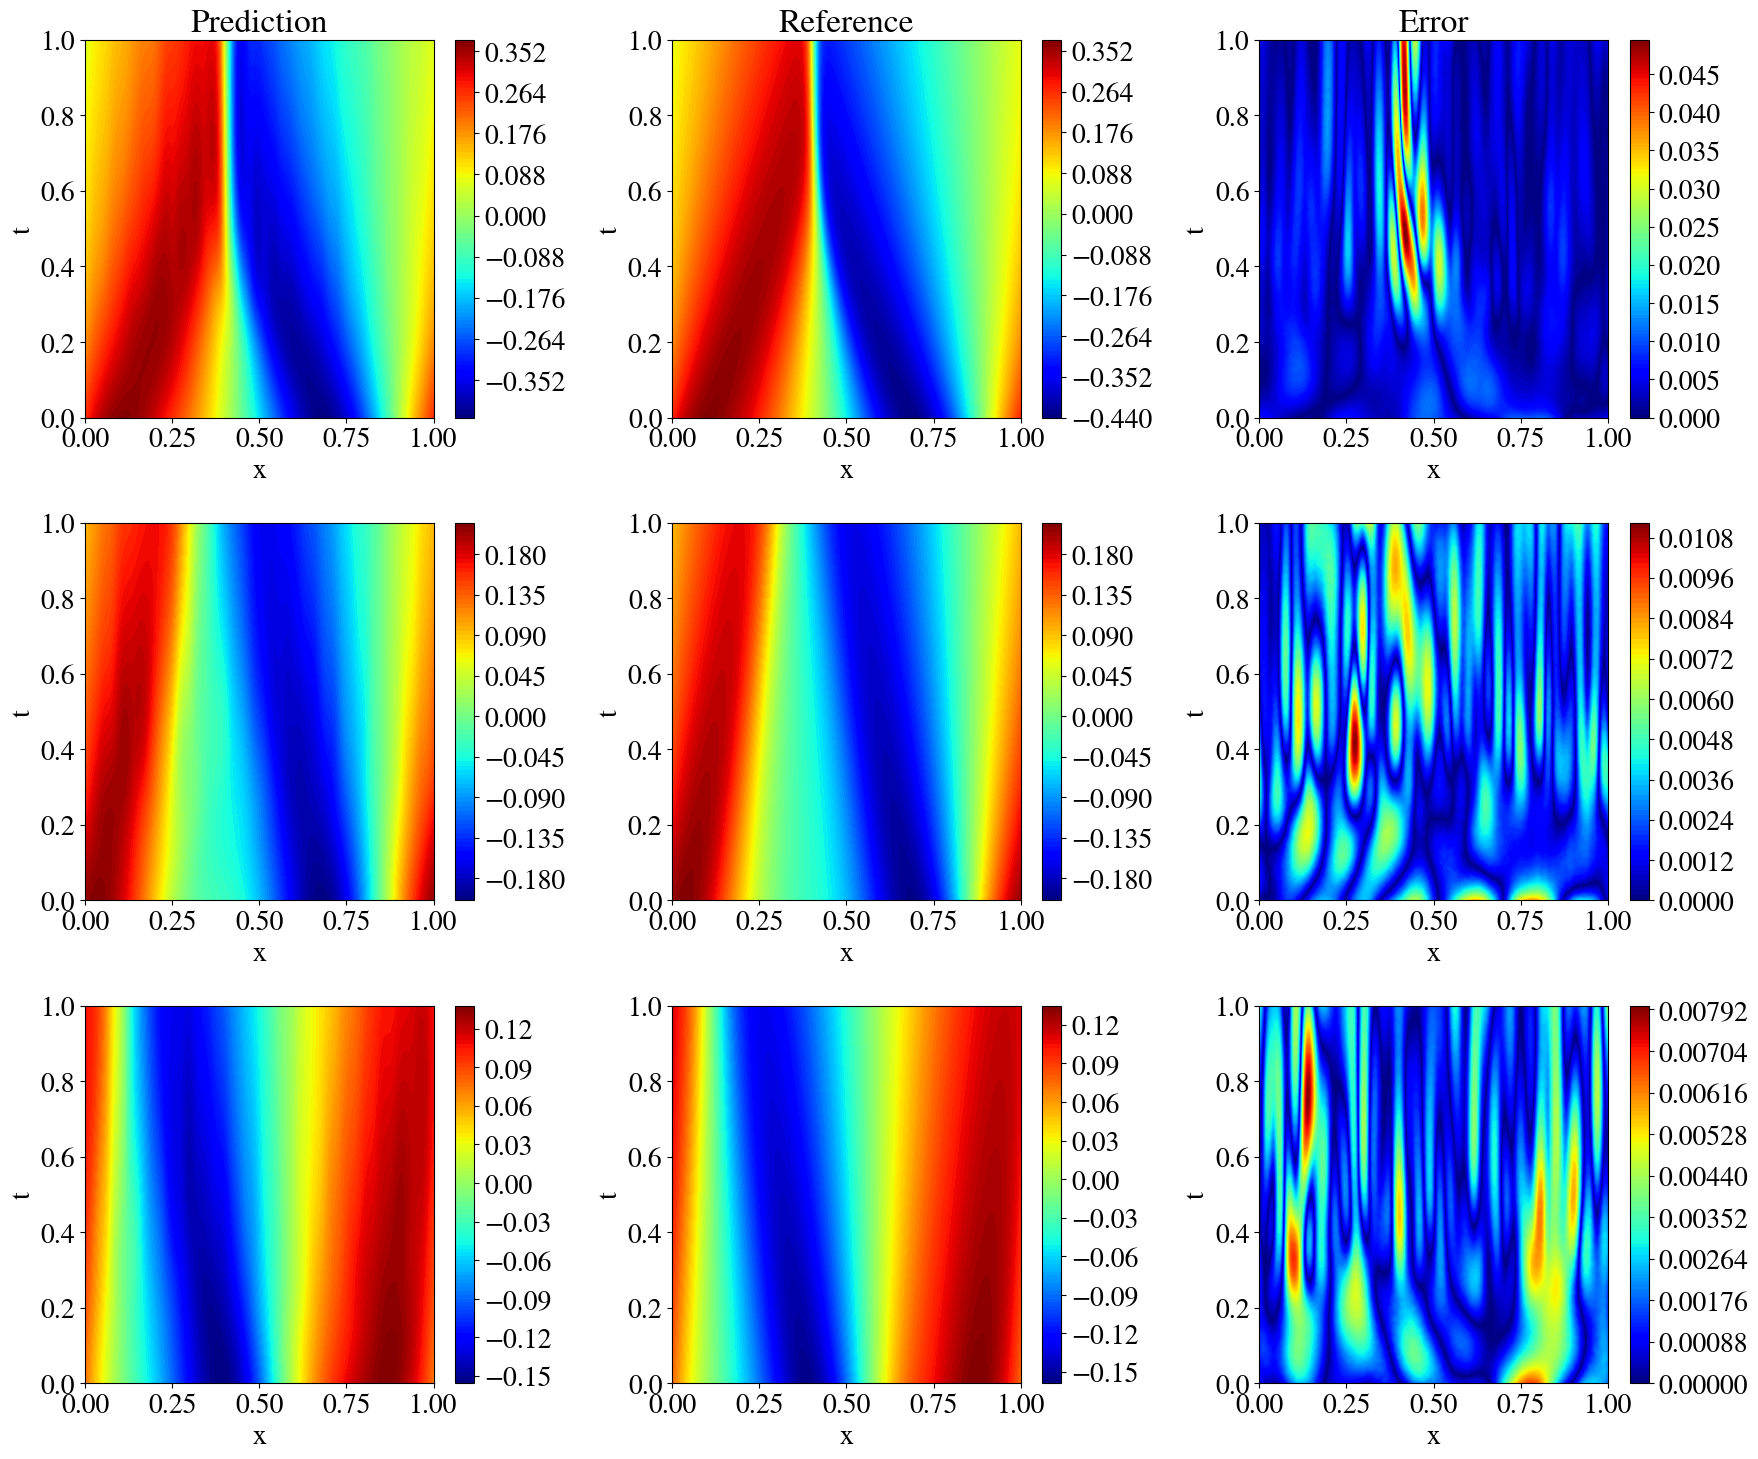

In [17]:
# Assuming X_Test, u_pred, N, np0 are already defined in your environment
samples = [15, 50, 499]

# Generate a uniform mesh
x = np0.linspace(0, 1, N)
t = np0.linspace(0, 1, N)
XX, TT = np0.meshgrid(x, t)

# Create a figure with 3 rows and 3 columns
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))

for row_idx, sample in enumerate(samples):
    # Retrieve the test and predicted data for the current sample
    u_test_sample = np0.array(X_Test['U'][sample])
    u_pred_sample = np0.array(u_pred[sample])

    # Compute the relative error
    error_s = np0.linalg.norm(u_test_sample - u_pred_sample, 2) / np0.linalg.norm(u_test_sample, 2)
    print(f"Sample {sample} error_s: {error_s:.3e}")

    # Grid data
    S_pred = griddata(X_Test['y'], u_pred_sample.flatten(), (XX, TT), method='cubic')
    S_test = griddata(X_Test['y'], u_test_sample.flatten(), (XX, TT), method='cubic')
    pointwise_error = np0.abs(S_test - S_pred)

    # Plot Real u
    ax = axes[row_idx, 1]
    contour1 = ax.contourf(XX, TT, S_test, levels=100, cmap='jet')
    fig.colorbar(contour1, ax=ax)
    if row_idx==0:
        ax.set_title(f'Reference')
    ax.set_xlabel('x')
    ax.set_ylabel('t')

    # Plot Predicted u
    ax = axes[row_idx, 0]
    contour2 = ax.contourf(XX, TT, S_pred, levels=100, cmap='jet')
    fig.colorbar(contour2, ax=ax)
    if row_idx==0:
        ax.set_title(f'Prediction')
    ax.set_xlabel('x')
    ax.set_ylabel('t')

    # Plot Pointwise Error
    ax = axes[row_idx, 2]
    contour3 = ax.contourf(XX, TT, pointwise_error, levels=100, cmap='jet')
    fig.colorbar(contour3, ax=ax)
    if row_idx==0:
        ax.set_title(f'Error')
    ax.set_xlabel('x')
    ax.set_ylabel('t')

plt.tight_layout()
plt.savefig('QR_DN_results.png')
plt.show()

# If needed, update JAX configuration
jax.config.update("jax_enable_x64", False)
